# Sheep coordinates from genome project have missing data
The latest coordinate information from *ISGC* lacks of variants which are present in chip. The latest coordinates were downloaded from [ISGC](https://figshare.com/articles/dataset/Mapping_of_ISGC_SNP_chip_probes/8424935/2). 

* [About SNP50](#about-snp-50)
* [About SNPHD](#about-snp-hd)
* [Mismatches between datasets](#mismatches-between-datasets)

First of all define some helper functions:

In [1]:
import os
import csv
import pandas
import random

from collections import namedtuple, defaultdict

from pymongo import MongoClient
import matplotlib.pyplot as plt

from src.data.common import WORKING_ASSEMBLIES
from src.features.utils import get_project_dir, text_or_gzip_open, get_interim_dir
from src.features.smarterdb import global_connection, VariantSheep, SMARTERDB

# connect to database
global_connection()

# in order to do aggregation queries, make another connection:
conn = MongoClient(
    'mongodb://localhost:27017/',
    username=os.getenv("MONGODB_SMARTER_USER"),
    password=os.getenv("MONGODB_SMARTER_PASS")
)

# get the smarter assembly I want to test
OAR3 = WORKING_ASSEMBLIES['OAR3']
OAR4 = WORKING_ASSEMBLIES['OAR4']

# define the source data file
data_dir = get_project_dir() / "data/external/SHE/CONSORTIUM"
ovine_snp50_oar3 = data_dir / "OvineSNP50_B.csv_v3.1_pos_20190513.csv.gz"
ovine_snp50_oar4 = data_dir / "OvineSNP50_B.csvv4.0_pos_20190513.csv.gz"
ovine_snpHD_oar3 = data_dir / "SheepHD_AgResearch_Cons_15041608_A.csv_v3.1_pos_20190513.csv.gz"
ovine_snpHD_oar4 = data_dir / "SheepHD_AgResearch_Cons_15041608_A.csvv4.0_pos_20190513.csv.gz"

# define a folder in which put all results of such explorative analyses:
result_dir = get_interim_dir() / "issue-18"
result_dir.mkdir(parents=True, exist_ok=True)


# some helpers function
def process_coordinates(datafile):
    with text_or_gzip_open(datafile) as handle:
        reader = csv.reader(handle, delimiter=",")
        header = next(reader)
        Record = namedtuple("Record", header)
        for line in reader:
            # fix position column
            idx = header.index('pos')
            line[idx] = int(line[idx])

            # fix allele format
            idx = header.index('alleles')
            line[idx] = "/".join(list(line[idx]))

            # make a record from csv line
            record = Record._make(line)
            
            yield record

<a id='about-snp-50'></a>
## About SNP50

First consideration: I have more SNPs in *smarter* database than the ones I have in the provided files:

In [2]:
# get all variant names from SNP50. 
pipeline = [{'$match': {'chip_name': 'IlluminaOvineSNP50'}}, {"$project": {"_id": 0, "name": 1}}]
results = conn[SMARTERDB]["variantSheep"].aggregate(pipeline)

# Track names in a set and count them
snp50_in_db = set([item["name"] for item in results])
n_snp50_in_db = len(snp50_in_db)

# now track data in files
snp50_oar3_isgc = set([record.entry for record in process_coordinates(ovine_snp50_oar3)])
n_snp50_oar3 = len(snp50_oar3_isgc)

snp50_oar4_isgc = set([record.entry for record in process_coordinates(ovine_snp50_oar4)])
n_snp50_oar4 = len(snp50_oar4_isgc)

print(f"I have {n_snp50_in_db} SNPs in the database for 'IlluminaOvineSNP50'")
print(f"I have {n_snp50_oar3} and {n_snp50_oar4} SNPs for 'OAR3' and 'OAR4' respectively in data files for the same chip")
print(f"(Missing {n_snp50_in_db - n_snp50_oar3} SNPs for 'OAR3' and {n_snp50_in_db - n_snp50_oar4} for 'OAR4')")

I have 54241 SNPs in the database for 'IlluminaOvineSNP50'
I have 47015 and 47019 SNPs for 'OAR3' and 'OAR4' respectively in data files for the same chip
(Missing 7226 SNPs for 'OAR3' and 7222 for 'OAR4')


There are ~13% missing SNPs in *ISGC* data files. Plot them as a chart:

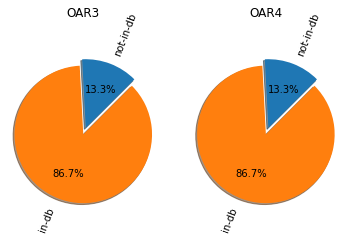

In [3]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['not-in-db', 'in-db']
oar3_sizes = [n_snp50_in_db-n_snp50_oar3, n_snp50_oar3]
oar4_sizes = [n_snp50_in_db-n_snp50_oar4, n_snp50_oar4]
explode = (0.1, 0)  # only "explode" the 1nd slice (i.e. 'Not-in-db')

# horizontally stacked subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.pie(oar3_sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=45, rotatelabels=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("OAR3")

ax2.pie(oar4_sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=45, rotatelabels=45)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title("OAR4")

plt.show()

Which *SNP50* snps are currently missing in *ISGC* dataset? track them in a file

In [4]:
missing50_oar3 = snp50_in_db.difference(snp50_oar3_isgc)

with open(result_dir / "isgc-50-missing_snps-oar3.csv", "w") as handle:
    writer = csv.writer(handle, delimiter=",", lineterminator="\n")
    header = ["name", "smarter_chr", "smarter_pos"]
    writer.writerow(header)
    
    for name in missing50_oar3:
        variant = VariantSheep.objects(name=name).fields(pk=0, rs_id=1, name=1, elemMatch__locations=OAR3._asdict()).get()
        location = variant.locations[0]
        line = [name, location.chrom, location.position]
        writer.writerow(line)

# do the same for OAR4
missing50_oar4 = snp50_in_db.difference(snp50_oar4_isgc)

with open(result_dir / "isgc-50-missing_snps-oar4.csv", "w") as handle:
    writer = csv.writer(handle, delimiter=",", lineterminator="\n")
    header = ["name", "smarter_chr", "smarter_pos"]
    writer.writerow(header)
    
    for name in missing50_oar4:
        variant = VariantSheep.objects(name=name).fields(pk=0, rs_id=1, name=1, elemMatch__locations=OAR4._asdict()).get()
        location = variant.locations[0]
        line = [name, location.chrom, location.position]
        writer.writerow(line)

Get a sample of such missing SNPs and see where they falls. Do this for *OAR3*:

In [5]:
random.seed(a=42, version=2)
selected50_oar3 = random.sample(sorted(list(missing50_oar3)), 20)

data = defaultdict(list)

for name in selected50_oar3:
    variant = VariantSheep.objects(name=name).fields(pk=0, rs_id=1, name=1, elemMatch__locations=OAR3._asdict()).get()
    location = variant.locations[0]
    
    data["name"].append(variant.name)
    data["chrom"].append(location.chrom)
    data["position"].append(location.position)

pandas.DataFrame.from_dict(data)

,name,chrom,position
0,s14962.1,23,38504505
1,OAR16_56458897.1,0,0
2,OAR10_63078224.1,10,61538148
3,s39911.1,2,93102704
4,OAR24_8533480.1,24,7366298
5,OAR21_43934463.1,21,39990742
6,OAR1_98069576.1,1,92399048
7,OAR18_38485433.1,18,36434675
8,s38770.1,2,86669812
9,OAR16_16543821.1,16,14944699


Most of the missing SNPs seems to have a location (we are not deleting SNPs with no positions!)

<a id='about-snp-hd'></a>
## About SNPHD
Even *HD* chip have less SNPs than I have in database:

In [6]:
# get all variant names from SNP50. 
pipeline = [{'$match': {'chip_name': 'IlluminaOvineHDSNP'}}, {"$project": {"_id": 0, "name": 1}}]
results = conn[SMARTERDB]["variantSheep"].aggregate(pipeline)

# Track names in a set and count them
snpHD_in_db = set([item["name"] for item in results])
n_snpHD_in_db = len(snpHD_in_db)

# now track data in files
snpHD_oar3_isgc = set([record.entry for record in process_coordinates(ovine_snpHD_oar3)])
n_snpHD_oar3 = len(snpHD_oar3_isgc)

snpHD_oar4_isgc = set([record.entry for record in process_coordinates(ovine_snpHD_oar4)])
n_snpHD_oar4 = len(snpHD_oar4_isgc)

print(f"I have {n_snpHD_in_db} SNPs in the database for 'IlluminaOvineHDSNP'")
print(f"I have {n_snpHD_oar3} and {n_snpHD_oar4} SNPs for 'OAR3' and 'OAR4' respectively in data files for the same chip")
print(f"(Missing {n_snpHD_in_db - n_snpHD_oar3} SNPs for 'OAR3' and {n_snpHD_in_db - n_snpHD_oar4} for 'OAR4')")

I have 605998 SNPs in the database for 'IlluminaOvineHDSNP'
I have 595291 and 595205 SNPs for 'OAR3' and 'OAR4' respectively in data files for the same chip
(Missing 10707 SNPs for 'OAR3' and 10793 for 'OAR4')


Graph them. However, missing SNPs are less than 2% of the dataset:

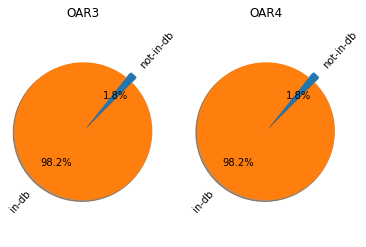

In [7]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['not-in-db', 'in-db']
oar3_sizes = [n_snpHD_in_db-n_snpHD_oar3, n_snpHD_oar3]
oar4_sizes = [n_snpHD_in_db-n_snpHD_oar4, n_snpHD_oar4]
explode = (0.1, 0)  # only "explode" the 1nd slice (i.e. 'Not-in-db')

# horizontally stacked subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.pie(oar3_sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=45, rotatelabels=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("OAR3")

ax2.pie(oar4_sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=45, rotatelabels=45)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title("OAR4")

plt.show()

Track HD missing SNPs in a file:

In [8]:
missingHD_oar3 = snpHD_in_db.difference(snpHD_oar3_isgc)

with open(result_dir / "isgc-HD-missing_snps-oar3.csv", "w") as handle:
    writer = csv.writer(handle, delimiter=",", lineterminator="\n")
    header = ["name", "smarter_chr", "smarter_pos"]
    writer.writerow(header)
    
    for name in missingHD_oar3:
        variant = VariantSheep.objects(name=name).fields(pk=0, rs_id=1, name=1, elemMatch__locations=OAR3._asdict()).get()
        location = variant.locations[0]
        line = [name, location.chrom, location.position]
        writer.writerow(line)

# do the same for OAR4
missingHD_oar4 = snpHD_in_db.difference(snpHD_oar4_isgc)

with open(result_dir / "isgc-HD-missing_snps-oar4.csv", "w") as handle:
    writer = csv.writer(handle, delimiter=",", lineterminator="\n")
    header = ["name", "smarter_chr", "smarter_pos"]
    writer.writerow(header)
    
    for name in missingHD_oar4:
        variant = VariantSheep.objects(name=name).fields(pk=0, rs_id=1, name=1, elemMatch__locations=OAR4._asdict()).get()
        location = variant.locations[0]
        line = [name, location.chrom, location.position]
        writer.writerow(line)

Get a sample of such missing SNPs and see where they falls. Do this for *OAR3*:

In [9]:
random.seed(a=42, version=2)
selectedHD_oar3 = random.sample(sorted(list(missingHD_oar3)), 20)

data = defaultdict(list)

for name in selectedHD_oar3:
    variant = VariantSheep.objects(name=name).fields(pk=0, rs_id=1, name=1, elemMatch__locations=OAR3._asdict()).get()
    location = variant.locations[0]
    
    data["name"].append(variant.name)
    data["chrom"].append(location.chrom)
    data["position"].append(location.position)

pandas.DataFrame.from_dict(data)

,name,chrom,position
0,s66483.1,5,46430611
1,OAR2_110874001.1,2,103237040
2,OAR13_76604248.1,13,71174943
3,oar3_OAR17_20994315,17,20994315
4,oar3_OAR14_2153591,14,2153591
5,oar3_OAR11_41120694,11,41120694
6,OAR3_168601266.1,0,0
7,OAR24_9426433.1,24,8251305
8,s04431.1,19,16066742
9,OAR20_46735384.1,20,43051993


<a id='mismatches-between-datasets'></a>
## Mismatches between datasets

Second consideration: there are mismatches in positions for some SNPs in common between the HD and 50 (ie the same SNP have different location in two data files for the same assembly). First get the SNPs in common between the two chips from the database:


In [10]:
# track all the snps in common between the two illumina chips
pipeline = [{'$match': {'chip_name': {'$all': ["IlluminaOvineSNP50", "IlluminaOvineHDSNP"]}}}, {"$project": {"_id": 0, "name": 1}}]
results = conn[SMARTERDB]["variantSheep"].aggregate(pipeline)
common_snps_names = set([item["name"] for item in results])

Next, for each record in the two data files, track the position I read from the file:

In [11]:
# initialize a dictionary with common names
common_snps = defaultdict(lambda: [None, None])

# process SNP50 for common snps and positions
for record in process_coordinates(ovine_snp50_oar3):
    if record.entry in common_snps_names:
        common_snps[record.entry][0] = record
    
# process SNPHD for common snps and positions
for record in process_coordinates(ovine_snpHD_oar3):
    if record.entry in common_snps_names:
        common_snps[record.entry][1] = record

So process each common SNPs. I could have missing data from one file, same positions for the same SNP (same assembly) and the case I want to show:

In [12]:
mismatches = []
missing = []

for key, [snp50, snpHD] in common_snps.items():
    if not snp50 or not snpHD:
        # some SNPs in common are missing in both files
        # print(f"Missing {key}")
        missing.append(key)
        continue
        
    if snp50.chrom != snpHD.chrom or snp50.pos != snpHD.pos:
        mismatches.append(key)

print(f"{len(missing)} common SNPs are missing")
print(f"There are {len(mismatches)} SNPs with different positions")

data = defaultdict(list)

for key in mismatches:
    snp50, snpHD = common_snps[key]
    snp50_pos = f"{snp50.chrom}:{snp50.pos}"
    snpHD_pos = f"{snpHD.chrom}:{snpHD.pos}"
    data["entry"].append(key)
    data["snp50"].append(snp50_pos)
    data["snpHD"].append(snpHD_pos)
    
pandas.DataFrame.from_dict(data)

633 common SNPs are missing
There are 41 SNPs with different positions


,entry,snp50,snpHD
0,OAR1_36892031.1,1:35921824,1:35921867
1,s13764.1,1:88483339,1:88483343
2,OAR1_149400642.1,1:138263045,1:138263042
3,OAR1_205005285.1,1:190060582,1:190060291
4,s75140.1,1:190608513,1:190608515
5,OAR1_240651665.1,1:223202691,1:223202701
6,s49200.1,1:262512895,1:262513664
7,s01225.1,1:263153610,16:27239006
8,OAR2_28934548.1,2:27912185,2:27912187
9,s47673.1,2:88986269,2:88985985


The same applies for *OAR4*:

In [13]:
# track all the snps in common between the two illumina chips
common_snps = defaultdict(lambda: [None, None])

# process SNP50 for common snps and positions
for record in process_coordinates(ovine_snp50_oar4):
    if record.entry in common_snps_names:
        common_snps[record.entry][0] = record
    
# process SNPHD for common snps and positions
for record in process_coordinates(ovine_snpHD_oar4):
    if record.entry in common_snps_names:
        common_snps[record.entry][1] = record

In [14]:
mismatches = []
missing = []

for key, [snp50, snpHD] in common_snps.items():
    if not snp50 or not snpHD:
        # some SNPs in common are missing in both files
        # print(f"Missing {key}")
        missing.append(key)
        continue
        
    if snp50.chrom != snpHD.chrom or snp50.pos != snpHD.pos:
        mismatches.append(key)

print(f"{len(missing)} common SNPs are missing")
print(f"There are {len(mismatches)} SNPs with different positions")

data = defaultdict(list)

for key in mismatches:
    snp50, snpHD = common_snps[key]
    snp50_pos = f"{snp50.chrom}:{snp50.pos}"
    snpHD_pos = f"{snpHD.chrom}:{snpHD.pos}"
    data["entry"].append(key)
    data["snp50"].append(snp50_pos)
    data["snpHD"].append(snpHD_pos)
    
pandas.DataFrame.from_dict(data)

634 common SNPs are missing
There are 41 SNPs with different positions


,entry,snp50,snpHD
0,OAR1_36892031.1,1:35864552,1:35864595
1,s13764.1,1:88357214,1:88357218
2,OAR1_149400642.1,1:138085166,1:138085163
3,OAR1_205005285.1,1:189890479,1:189890188
4,s75140.1,1:190436464,1:190436466
5,OAR1_240651665.1,1:223053301,1:223053311
6,s49200.1,1:262343539,1:262344308
7,s01225.1,1:262974976,16:27231030
8,OAR2_28934548.1,2:27925922,2:27925924
9,s47673.1,2:89026107,2:89025823
